# Acoustic Experiments

## Imports

In [1]:
%pylab inline

import numpy as np
import scipy as sp
import scipy.constants as const

from scipy.io import wavfile
from sklearn import preprocessing
from scipy import signal

from scipy.signal import butter, firwin, lfilter
from scipy.signal import freqz

Populating the interactive namespace from numpy and matplotlib


## Constants & Global Variables

In [2]:
input_data_directory = "data"
output_data_directory = "out"

sample_rate = 44100
duration = 0.1
samples = math.ceil(sample_rate * duration)
tone_frequency = 8820
tone_period = 1/tone_frequency

scaler = preprocessing.MinMaxScaler()

## Tone Generation

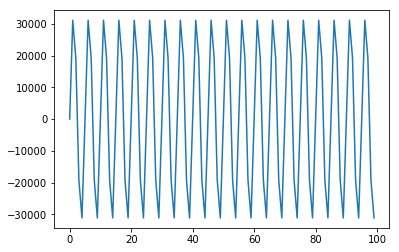

In [3]:
tone_path = input_data_directory+"/audio/tone.wav"

tone_data = np.sin(2 * math.pi * np.arange(samples) * tone_frequency / sample_rate) * 0x7FFF;
scaled_tone_data = scaler.fit_transform(np.reshape(tone_data,(tone_data.size,1)))

plt.figure()
plt.plot(tone_data[0:100])
wavfile.write(tone_path, sample_rate, tone_data.astype(np.int16))


## Load Sample Audio

In [4]:
sample_rate, sample_data = wavfile.read(input_data_directory+"/audio/sample.wav")
sample_duration = sample_data.size / sample_rate
print("Sample Rate: ",sample_rate,"\nSample Duration:",sample_duration)

scaled_sample_data = np.array(scaler.fit_transform(np.reshape(sample_data,(sample_data.size,1))).squeeze())

Sample Rate:  44100 
Sample Duration: 89.31555555555556


/home/pedro/ProgramFiles/Anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int16 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


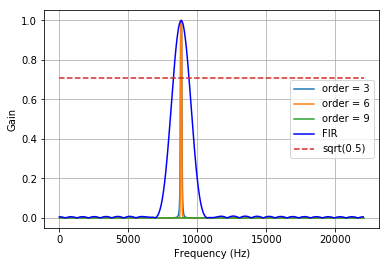

In [5]:
# Source: http://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
def butter_bandpass(low_cut_frequency, high_cut_frequency, sample_rate, order=5):
    nyq = 0.5 * sample_rate
    low = low_cut_frequency / nyq
    high = high_cut_frequency / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a

def butter_bandpass_filter(data, low_cut_frequency, high_cut_frequency, sample_rate, order=5):
    b, a = butter_bandpass(low_cut_frequency, high_cut_frequency, sample_rate, order=order)
    return lfilter(b, a, data)

def fir_bandpass(low_cut_frequency, high_cut_frequency, fs, order=5):
    nyq = 0.5 * fs
    b = firwin(order+1, [low_cut_frequency, high_cut_frequency], pass_zero=False, nyq=nyq)
    return b, [1.0]

def fir_bandpass_filter(data, low_cut_frequency, high_cut_frequency, fs, order=5):
    b, a = fir_bandpass(low_cut_frequency, high_cut_frequency, fs, order=order)
    return lfilter(b, a, data)

low_cut_frequency = tone_frequency - 50
high_cut_frequency = tone_frequency + 50

# Plot the frequency response for a few different filters and parameters.
plt.figure()
plt.clf()

for order in range(3,10,3):
    b, a = butter_bandpass(low_cut_frequency, high_cut_frequency, sample_rate, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((sample_rate * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

fir_order = 50
b, a = fir_bandpass(low_cut_frequency, high_cut_frequency, sample_rate, order=fir_order)
w, h = freqz(b)
plt.plot((sample_rate * 0.5 / np.pi) * w , abs(h), 'b', label="FIR")
    
plt.plot([0, 0.5 * sample_rate], [np.sqrt(0.5), np.sqrt(0.5)], '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

butler_order = 6
butler_filtered_sample_data = butter_bandpass_filter(scaled_sample_data,
                                                     low_cut_frequency,
                                                     high_cut_frequency,
                                                     sample_rate,
                                                     order=butler_order)

filtered_sample_data = butler_filtered_sample_data

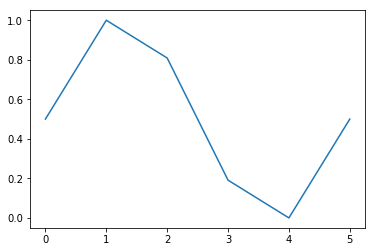

In [6]:
tone_match_data = scaled_tone_data[0:round(tone_period*sample_rate)+1].squeeze()
plt.figure()
plt.plot(tone_match_data)

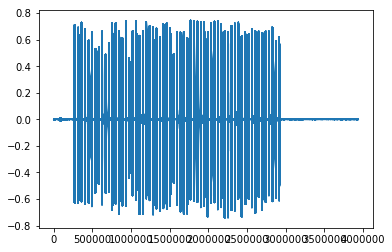

In [10]:
correlation = sp.correlate(filtered_sample_data, tone_match_data, 'valid')
plt.figure()
plt.plot(correlation)

In [11]:
treshold = 0.4
detected = False
last_index = 0
tone_indices = []

for index, value in enumerate(correlation):
    if value > treshold:
        if not detected:
            print ('Tone Detected at: ', index/sample_rate)
            tone_indices.append(index)            
        last_index = index
        detected = True
    elif index > last_index + sample_rate/2:
        detected = False
        
print("A total of ",len(tone_indices)," were detected.")

Tone Detected at:  6.125260770975057
Tone Detected at:  7.128548752834467
Tone Detected at:  8.124353741496599
Tone Detected at:  9.125374149659864
Tone Detected at:  10.130136054421769
Tone Detected at:  11.139909297052155
Tone Detected at:  12.126848072562359
Tone Detected at:  13.130702947845805
Tone Detected at:  14.143401360544217
Tone Detected at:  15.184331065759638
Tone Detected at:  16.172426303854877
Tone Detected at:  17.12390022675737
Tone Detected at:  18.12673469387755
Tone Detected at:  19.124943310657596
Tone Detected at:  20.12843537414966
Tone Detected at:  21.12390022675737
Tone Detected at:  22.12843537414966
Tone Detected at:  23.124943310657596
Tone Detected at:  24.124149659863946
Tone Detected at:  25.12562358276644
Tone Detected at:  26.12482993197279
Tone Detected at:  27.1243537414966
Tone Detected at:  28.1243537414966
Tone Detected at:  29.124603174603173
Tone Detected at:  30.12437641723356
Tone Detected at:  31.124716553287982
Tone Detected at:  32.124240